# calamp

> SLC amplitude calibration

In [ ]:
#| default_exp calamp

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
import zarr
from matplotlib import pyplot as plt
import colorcet
from moraine.utils_ import is_cuda_available

In [ ]:
#| export
import numpy as np
import math
import numba
from moraine.utils_ import is_cuda_available, get_array_module
if is_cuda_available():
    import cupy as cp

In [ ]:
#| export
@numba.jit(nopython=True, cache=True,parallel=True)
def _rslc2amp_numba(rslc):
    # support rslc and rslc stack
    rslc_shape = rslc.shape
    rslc = rslc.reshape(-1)
    amp = np.empty(rslc.shape,dtype=np.float32)
    for i in numba.prange(rslc.shape[0]):
        amp[i] = np.abs(rslc[i])
    return amp.reshape(rslc_shape)

In [ ]:
#| export
if is_cuda_available():
    def _rslc2amp_cp(rslc):
        return cp.abs(rslc)

In [ ]:
#| export
def rslc2amp(rslc:np.ndarray, # rslc, 2D/3D numpy array or cupy array
            )-> np.ndarray: # amplitude, 2D/3D numpy array or cupy array
    '''calculation the amplitude from SLC/SLC stack'''
    xp = get_array_module(rslc)
    if xp is np:
        return _rslc2amp_numba(rslc)
    else:
        return _rslc2amp_cp(rslc)

Usage:

In [ ]:
rslc = zarr.open('../CLI/raw/rslc.zarr/','r')[:,:,1]
amp = rslc2amp(rslc)
amp_ = np.abs(rslc)
np.testing.assert_array_almost_equal(amp,amp_,decimal=4)
if is_cuda_available():
    amp_gpu = rslc2amp(cp.asarray(rslc))
    np.testing.assert_array_almost_equal(amp,amp_gpu.get(),decimal=4)

In [ ]:
#| export
@numba.jit(nopython=True, cache=True,parallel=True)
def _calamp_numba(amp):
    nlines, width = amp.shape
    npixels = nlines*width
    
    amp = amp.reshape(npixels)
    nanamp_mean = np.float32(0.0)
    n_valid_pixel = np.int32(0)
    for i in numba.prange(npixels):
        if not np.isnan(amp[i]):
            nanamp_mean += amp[i]
            n_valid_pixel += 1
    nanamp_mean = nanamp_mean/n_valid_pixel
    amp_caled = np.empty(npixels,dtype=amp.dtype)
    for i in numba.prange(npixels):
            amp_caled[i] = amp[i]/nanamp_mean
    return amp_caled.reshape(nlines,width)

In [ ]:
#| export
if is_cuda_available():
    def _calamp_cp(amp):
        return amp/cp.nanmean(amp)

In [ ]:
#| export
def calamp(amp:np.ndarray, # amplitude, 2D numpy array or cupy array
            )-> np.ndarray: # calibrated amplitude, 2D numpy array or cupy array
    '''calculation the calibrated amplitude from amplitude of one single SLC'''
    xp = get_array_module(amp)
    if xp is np:
        return _calamp_numba(amp)
    else:
        return _calamp_cp(amp)

In [ ]:
rslc = zarr.open('../CLI/raw/rslc.zarr/','r')[:,:,0]
amp = np.abs(rslc)
amp_caled = calamp(amp)
if is_cuda_available():
    amp_gpu = cp.asarray(amp)
    amp_caled_gpu = calamp(amp_gpu)
    np.testing.assert_array_almost_equal(amp_caled,amp_caled_gpu.get(),decimal=3)
    # np.testing.assert_array_almost_equal(amp/np.nanmean(amp),amp_caled_gpu.get())

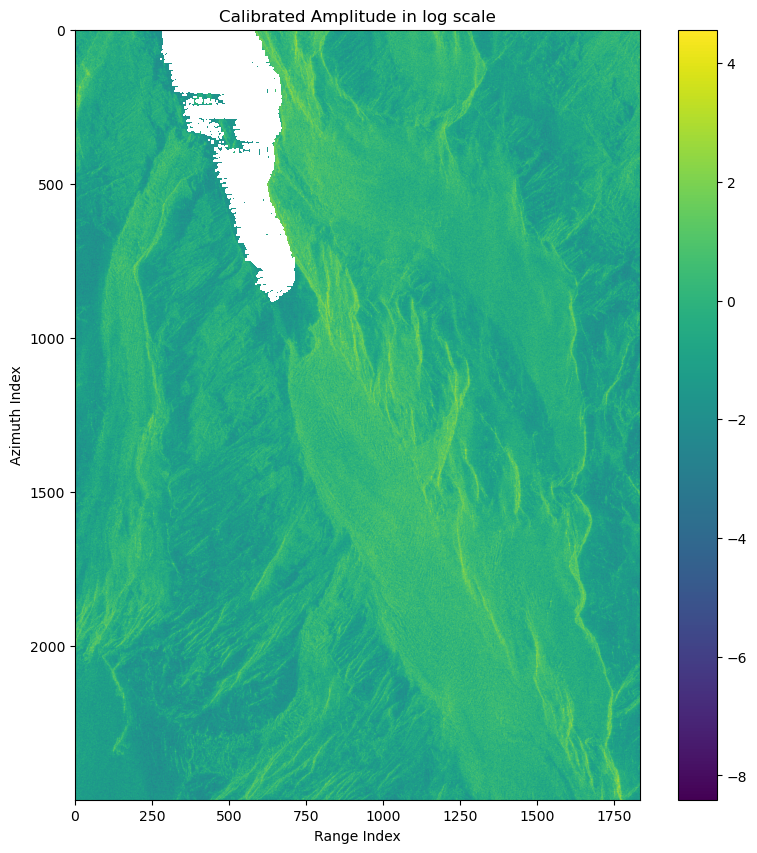

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(np.log(amp_caled))
ax.set(title='Calibrated Amplitude in log scale',xlabel='Range Index',ylabel='Azimuth Index')
fig.colorbar(pcm)
fig.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()